In [ ]:
import torch
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.','')
print(TORCH, CUDA)

import pickle
import os

2.5.0 cu121


In [ ]:
%%capture
!pip install pyg_lib -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-scatter     -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-geometric

In [ ]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm

from tqdm import tqdm

import math
from numba import cuda
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
def data_to_kNN(X,k):
  edge_index = torch_geometric.nn.knn_graph(X, k)
  edge_index = to_undirected(edge_index, num_nodes=X.shape[0])
  return edge_index

In [ ]:
def data_to_GNN_data(X,Y,k):
  dataset = []
  N = X.shape[0]
  for i in range(N):
    data = Data(x = X[i,:,:], y = Y[i,:,:], edge_index = data_to_kNN(X[i,:,:],k))
    data.num_nodes = 20
    data.num_edges = data.edge_index.shape[1]
    dataset.append(data)
  return dataset

def data_to_GNN_data_fm(X,Y,k):
  dataset = []
  N = len(X)
  for i in tqdm(range(N)):
    data = Data(x = X[i], y = Y[i], edge_index = data_to_kNN(X[i],k))
    data.num_nodes = X[i].shape[0]
    data.num_edges = data.edge_index.shape[1]
    dataset.append(data)
  return dataset

# Define the Models

In [ ]:
import torch
import scipy.io as sio
import torch.nn as nn

In [ ]:
# Throughout this we are going to assume that data is of the form B x N x D
# Where B is the batch size, N is the sequence length for the transformer
# this the number of data points. Finally D is the embedding dimension.
class SimpleAttention(nn.Module):
  # Initialize the parameter
  def __init__(self, hidden_dim):
    super(SimpleAttention, self).__init__()
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.WQ = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.WK = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.WV = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.skip = nn.Linear(hidden_dim, hidden_dim)
    self.attention = nn.MultiheadAttention(hidden_dim, 1, batch_first=True)

  # Forward pass
  def forward(self, input):
    Q = self.WQ(input)
    K = self.WK(input)
    V = self.WV(input)
    output_attention,_ = self.attention(Q,K,V)
    output_linear = self.linear(output_attention.relu()).relu()
    return output_linear + self.skip(input)

class SimpleTransformer(nn.Module):
# Initialize the parameter
  def __init__(self, input_dim, hidden_dim, out_dim, num_layers):
    super(SimpleTransformer, self).__init__()
    self.embed = nn.Linear(input_dim, hidden_dim)
    self.predictor = nn.Linear(hidden_dim, out_dim)
    self.AttentionLayers = []
    for i in range(num_layers):
      self.AttentionLayers.append(SimpleAttention(hidden_dim))

    self.AttentionLayers = nn.ModuleList(self.AttentionLayers)
    self.num_layers = num_layers

  # Forward pass
  def forward(self, z):
    z = self.embed(z)
    for i in range(self.num_layers):
      z = self.AttentionLayers[i](z)
    return self.predictor(z)


class FNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim, num_layers, d):
    super(FNN, self).__init__()
    self.embed = nn.Linear(input_dim, hidden_dim)
    self.predictor = nn.Linear(hidden_dim, out_dim)
    self.Layers = []
    for i in range(num_layers):
      self.Layers.append(nn.Linear(hidden_dim, hidden_dim))

    self.Layers = nn.ModuleList(self.Layers)
    self.num_layers = num_layers
    self.d = d

  # Input size B x N X 4
  def forward(self,x):
    x = torch.flatten(x, 1, 2) # B x N4
    x = self.embed(x).relu()
    for i in range(self.num_layers):
      x = self.Layers[i](x).relu()
    x = self.predictor(x)
    x = torch.unflatten(x, 1, (-1,self.d))
    return x

def kernel_basis(X, d1, d2):
  N = X.shape[0]
  d = X.shape[1]

  Phi = torch.zeros(N, (d1+2*d2)*d, device = X.device)
  for i in range(d1+2*d2):
    if i < d1:
      for j in range(d):
        Phi[:,d*i+j] = X[:,j].pow(i+1)
    elif i < d1+d2:
      for j in range(d):
        k = i-d1+1
        Phi[:,d*i+j] = (X[:,j]*k).sin()
    else:
      for j in range(d):
        k = i-d1-d2+1
        Phi[:,d*i+j] = torch.cos(X[:,j]*k)

  return Phi

class Kernel(nn.Module):
  def __init__(self, feature_dim, out_dim, d, embed=kernel_basis):
    super(Kernel, self).__init__()
    self.predictor = nn.Linear(feature_dim, out_dim, device = "cuda")
    self.embed = embed
    self.d = d

  # Input size B x N X 4
  def forward(self,x):
    x = self.predictor(x)
    x = torch.unflatten(x, 1, (-1,self.d))
    return x


In [ ]:
def get_nn(in_channels, out_channels):
  return torch.nn.Sequential(torch.nn.Linear(in_channels, out_channels), torch.nn.ReLU(),
                             torch.nn.Linear(out_channels, out_channels))

class GNN(torch.nn.Module):
  def __init__(self, node_input_dim, output_dim, num_layers, hidden_dim = 128, device = "cuda", arch = "Graph"):
    super().__init__()

    self.num_layers = num_layers
    self.layers = []
    if arch == "Transformer":
      self.layers.append(torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim).to(device))
      for i in range(num_layers-1):
        self.layers.append(torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim).to(device))
    elif arch == "Graph":
      self.layers.append(torch_geometric.nn.GraphConv(node_input_dim, hidden_dim).to(device))
      for i in range(num_layers-1):
        self.layers.append(torch_geometric.nn.GraphConv(hidden_dim, hidden_dim).to(device))
    elif arch == "GIN":
      self.layers.append(torch_geometric.nn.GINConv(get_nn(node_input_dim, hidden_dim)).to(device))
      for i in range(num_layers-1):
        self.layers.append(torch_geometric.nn.GINConv(get_nn(hidden_dim, hidden_dim)).to(device))

    self.layers = torch.nn.ModuleList(self.layers)
    self.lin = torch.nn.Linear(hidden_dim, output_dim).to(device)

  def forward(self, x, edge_index, batch):
    for i in range(self.num_layers):
      x = self.layers[i](x, edge_index).relu()

    z = self.lin(x)
    return z

# Code for Simulating

In [ ]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import torch

def CS(t,z,N):

  dxdt = np.zeros(N); dydt = np.zeros(N)
  dudt = np.zeros(N); dvdt = np.zeros(N)

  x = z[0:N]; y = z[N:2*N]
  u = z[2*N:3*N]; v = z[3*N:]

  Fx = np.zeros((N,N)); Fy = np.zeros((N,N))

  for i in range(0,N):
    for j in range(0,N):
        Fx[i,j] = (1/N)*Phi(np.linalg.norm(np.array([x[i]-x[j], y[i]-y[j]])))*(u[j]-u[i])
        Fy[i,j] = (1/N)*Phi(np.linalg.norm(np.array([x[i]-x[j], y[i]-y[j]])))*(v[j]-v[i])

  for i in range(0,N):
    dxdt[i] = u[i]
    dydt[i] = v[i]
    dudt[i] = np.sum(Fx[i,:])
    dvdt[i] = np.sum(Fy[i,:])

  dzdt = np.concatenate((dxdt, dydt, dudt, dvdt))
  return dzdt

def Phi(r):
   H = 1; s = 1; b = 1
   y = H/(s**2+r**2)**b
   return y

# %%%%%%%%%%%%%%%%%%%%%%% Main %%%%%%%%%%%%%%%%%%%%%%%

N = 20 # Number of agents
T = 100 # Final time

x0 = np.random.uniform(0,1,N)
y0 = np.random.uniform(0,1,N)
u0 = np.random.uniform(0,1,N)
v0 = np.random.uniform(0,1,N)
z0 = np.concatenate((x0,y0,u0,v0))

t_eval = torch.tensor(range(0,500))*T/500

## For Other Models

In [ ]:
def resize_tensor(A):
  N, T = A.shape
  n = N//4
  new_A = torch.zeros(T, N//4, 4)

  new_A[:,:,0] = A.T[:,:n]
  new_A[:,:,1] = A.T[:,n:2*n]
  new_A[:,:,2] = A.T[:,2*n:3*n]
  new_A[:,:,3] = A.T[:,3*n:]

  return new_A

In [ ]:
def CS_Transformer(t,z,N):

  z = torch.tensor(z).unsqueeze(-1)

  x = resize_tensor(z).to('cuda')
  y = model(x)[0,:]
  out = torch.cat((y[:,0],y[:,1],y[:,2],y[:,3]), dim=0)

  return out.cpu().detach().numpy()

In [ ]:
def CS_TGNN(t,z,N):
  model_gnn.eval()
  z = torch.tensor(z).unsqueeze(-1)
  x = resize_tensor(z).to('cuda')
  data = data_to_GNN_data(x,x,20)[0]
  y = model_tgnn(data.x, data.edge_index, None)
  out = torch.cat((y[:,0],y[:,1],y[:,2],y[:,3]), dim=0)

  return out.cpu().detach().numpy()

In [ ]:
def CS_GCN(t,z,N):
  model_gnn.eval()
  z = torch.tensor(z).unsqueeze(-1)
  x = resize_tensor(z).to('cuda')
  data = data_to_GNN_data(x,x,20)[0]
  y = model_gcn(data.x, data.edge_index, None)
  out = torch.cat((y[:,0],y[:,1],y[:,2],y[:,3]), dim=0)

  return out.cpu().detach().numpy()

In [ ]:
def CS_FNN(t,z,N):

  z = torch.tensor(z).unsqueeze(-1)

  x = resize_tensor(z).to('cuda')
  y = model_fnn(x)[0,:]
  out = torch.cat((y[:,0],y[:,1],y[:,2],y[:,3]), dim=0)

  return out.cpu().detach().numpy()

# Testing Evolving the Dynamical System



In [ ]:
model = torch.load("drive/MyDrive/MeasureMaps/Transformer/trial-0-depth-5-width-256-lr-0.0002-epoch-1000.pt")
# model_fnn = torch.load("drive/MyDrive/MeasureMaps/FNN/trial-0-depth-5-width-512-lr-0.001-epoch-1000.pt")
# model_tgnn = torch.load("drive/MyDrive/MeasureMaps/GNN/TransformerConv Full/trial-0-depth-5-width-256-lr-0.001-epoch-1000.pt")
# model_gcn = torch.load("drive/MyDrive/MeasureMaps/GNN/GraphConv Full/trial-0-depth-3-width-256-lr-0.001-epoch-1000.pt")

<ipython-input-16-9bc91354f5c9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("drive/MyDrive/MeasureMaps/Transformer/trial-0-depth-5-width-256-lr-0.000

In [ ]:
N = 20 # Number of agents
T = 100 # Final time

x0 = np.random.uniform(0,1,N)
y0 = np.random.uniform(0,1,N)
u0 = np.random.uniform(0,1,N)
v0 = np.random.uniform(0,1,N)
z0 = np.concatenate((x0,y0,u0,v0))

In [ ]:
cs_gcn = CS_GCN(0,z0,N)
cs_gcn

In [ ]:
cs_y = CS(0,z0,N)
cs_y

In [ ]:
cs_t = CS_Transformer(0,z0,N)
cs_t

In [ ]:
cs_f = CS_FNN(0,z0,N)
cs_f

In [ ]:
cs_tgnn = CS_TGNN(0,z0,N)
cs_tgnn

In [ ]:
np.mean(np.abs((cs_tgnn-cs_y)/cs_y))

0.011678062733793234

In [ ]:
t_error = torch.zeros(100,500,4)
# f_error = torch.zeros(100,50,4)
# g_error = torch.zeros(100,50,4)

for i in tqdm(range(100)):
  N = 20 # Number of agents
  T = 20 # Final time

  x0 = np.random.uniform(0,1,N)
  y0 = np.random.uniform(0,1,N)
  u0 = np.random.uniform(0,1,N)
  v0 = np.random.uniform(0,1,N)
  z0 = np.concatenate((x0,y0,u0,v0))

  t_eval = torch.tensor(range(0,500))*T/500

  soln_t = integrate.solve_ivp(CS_Transformer, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

  x_t = soln_t.y[0:N,:]; y_t = soln_t.y[N:2*N,:];
  u_t = soln_t.y[2*N:3*N,:]; v_t = soln_t.y[3*N:4*N,:]

  t_eval = torch.tensor(range(0,500))*T/500

  soln_cs = integrate.solve_ivp(CS, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

  x_cs = soln_cs.y[0:N,:]; y_cs = soln_cs.y[N:2*N,:];
  u_cs = soln_cs.y[2*N:3*N,:]; v_cs = soln_cs.y[3*N:4*N,:]

  # t_eval = torch.tensor(range(0,50))*T/50

  # soln_fnn = integrate.solve_ivp(CS_FNN, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

  # x_fnn = soln_fnn.y[0:N,:]; y_fnn = soln_fnn.y[N:2*N,:];
  # u_fnn = soln_fnn.y[2*N:3*N,:]; v_fnn = soln_fnn.y[3*N:4*N,:]

  # t_eval = torch.tensor(range(0,50))*T/50

  # soln_tgnn = integrate.solve_ivp(CS_TGNN, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

  # x_tgnn = soln_tgnn.y[0:N,:]; y_tgnn = soln_tgnn.y[N:2*N,:];
  # u_tgnn = soln_tgnn.y[2*N:3*N,:]; v_tgnn = soln_tgnn.y[3*N:4*N,:]

  t_error[i,:,0] += torch.tensor(x_t - x_cs).abs().mean(dim = 0) /100
  # f_error[i,:,0] += torch.tensor(x_fnn - x_cs).abs().mean(dim = 0) /100
  # g_error[i,:,0] +=torch.tensor(x_tgnn - x_cs).abs().mean(dim = 0) /100

  t_error[i,:,1] += torch.tensor(y_t - y_cs).abs().mean(dim = 0) /100
  # f_error[i,:,1] += torch.tensor(y_fnn - y_cs).abs().mean(dim = 0) /100
  # g_error[i,:,1] += torch.tensor(y_tgnn - y_cs).abs().mean(dim = 0) /100

  t_error[i,:,2] += torch.tensor(u_t - u_cs).abs().mean(dim = 0) /100
  # f_error[i,:,2] += torch.tensor(u_fnn - u_cs).abs().mean(dim = 0) /100
  # g_error[i,:,2] += torch.tensor(u_tgnn - u_cs).abs().mean(dim = 0) /100

  t_error[i,:,3] += torch.tensor(v_t - v_cs).abs().mean(dim = 0) /100
  # f_error[i,:,3] += torch.tensor(v_fnn - v_cs).abs().mean(dim = 0) /100
  # g_error[i,:,3] += torch.tensor(v_tgnn - v_cs).abs().mean(dim = 0) /100

100%|██████████| 100/100 [32:44<00:00, 19.64s/it]


In [ ]:
t_error.shape

torch.Size([100, 500, 4])

In [ ]:
t_eval = torch.tensor(range(0,500))*T/500
t_eval.shape

torch.Size([500])

In [ ]:
def plot_median_and_iqr(data, time_steps=None, fig = None, ax = None, title="Median and IQR over Time",
                        xlabel="Time", ylabel="Error", color='blue', alpha=0.3, label = "label"):
    """
    Create a plot showing the median line and interquartile range over time.

    Parameters:
    data (np.array): 2D array where each row is a trial and each column is a time point
    time_steps (list or np.array, optional): List of time points. If None, will use column indices.
    title (str): Title of the plot
    xlabel, ylabel (str): Labels for the axes
    color (str): Color for the median line and shaded area
    alpha (float): Transparency for the shaded area (0-1)
    """

    if time_steps is None:
        time_steps = np.arange(data.shape[1])

    # Calculate median and quartiles
    median = np.median(data, axis=0)
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)

    # Plot the median line
    ax.plot(time_steps, median, color=color, label=label)

    # Shade the IQR
    ax.fill_between(time_steps, q1, q3, color=color, alpha=alpha)

    # Set labels and title
    ax.set_xlabel(xlabel, fontsize = 32)
    ax.set_ylabel(ylabel, fontsize = 32)
    # ax.set_title(title)

    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add a legend
    ax.legend(fontsize = 32)

    # Show the grid
    ax.grid(True, linestyle='--', alpha=0.7)

    offset_text = ax.get_yaxis().get_offset_text()

    # Set the font size of the offset text
    offset_text.set_fontsize(32)

    plt.tight_layout()
    return fig, ax

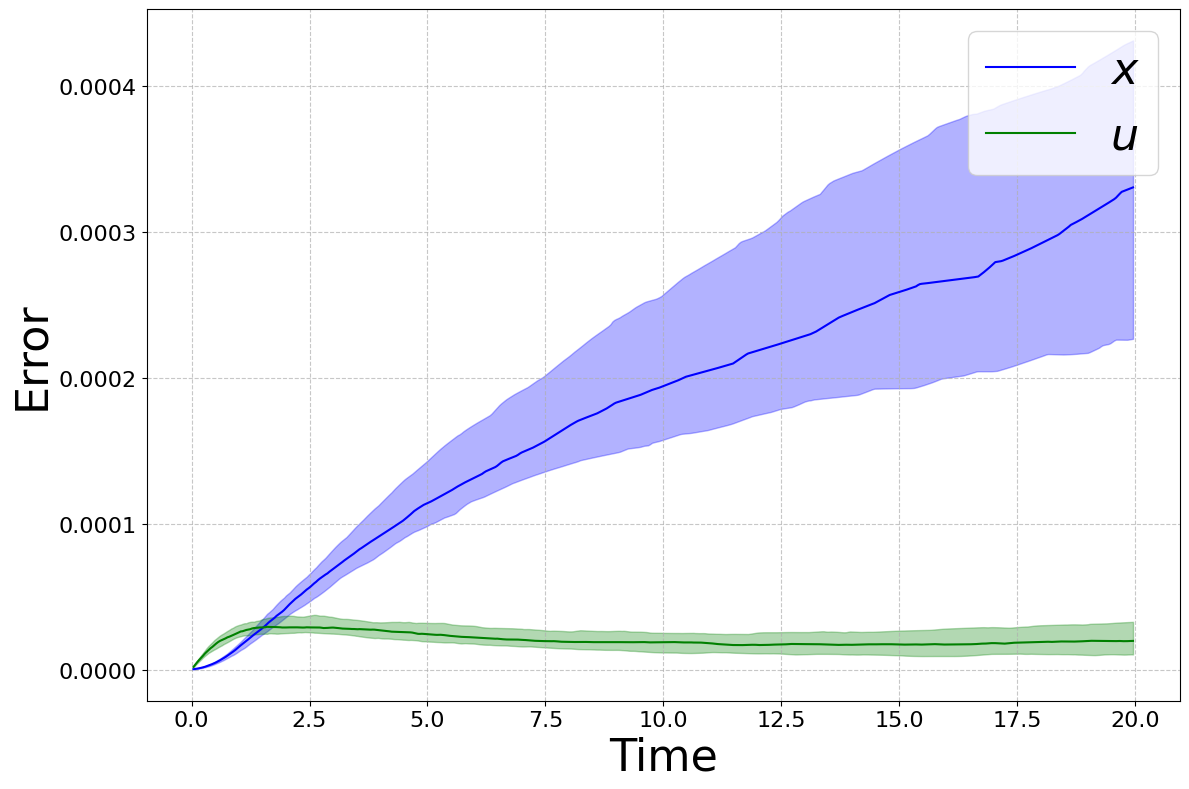

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig, ax = plot_median_and_iqr(t_error[:,1:,0], time_steps = t_eval[1:], fig = fig, ax = ax, label = r"$x$")
fig, ax = plot_median_and_iqr(t_error[:,1:,2], time_steps = t_eval[1:], fig = fig, ax = ax, label = r"$u$", color = "green")
plt.savefig("x-errors.pdf", bbox_inches='tight', dpi = 100)

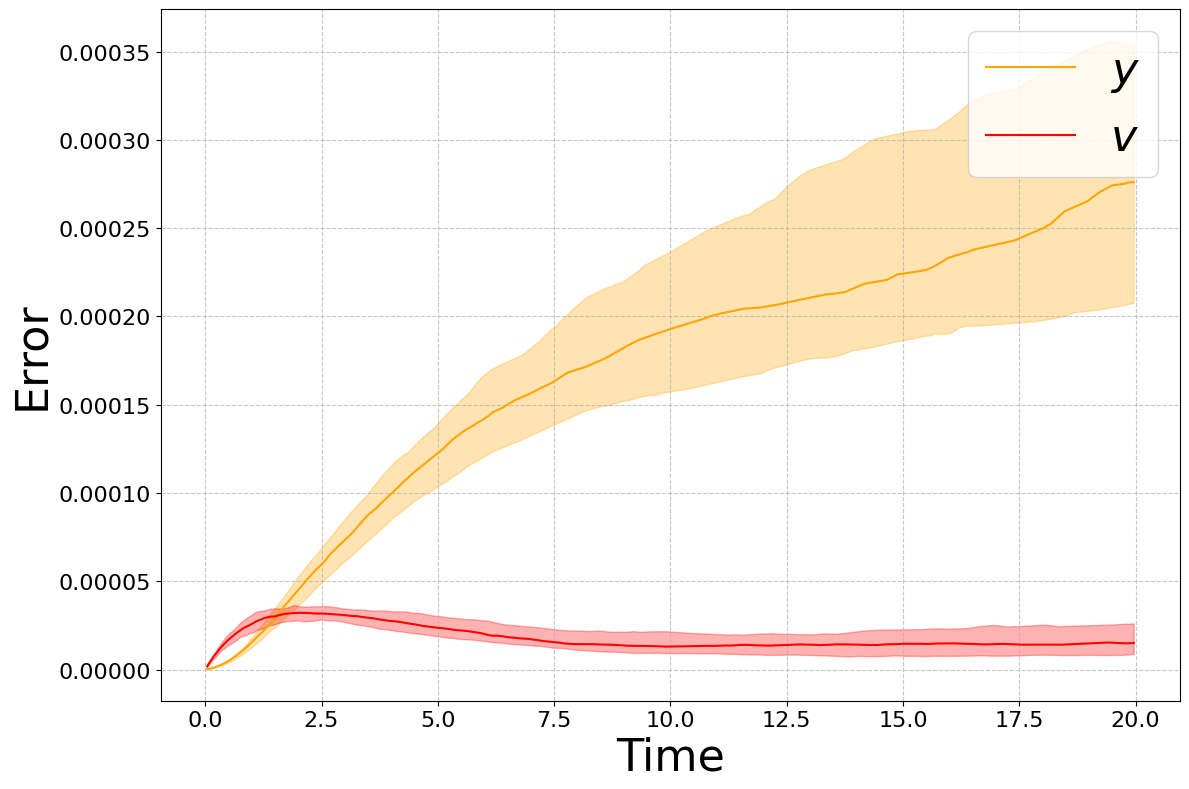

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig, ax = plot_median_and_iqr(t_error[:,1:,1], time_steps = t_eval[1:], fig = fig, ax = ax, label = r"$y$", color = "orange")
fig, ax = plot_median_and_iqr(t_error[:,1:,3], time_steps = t_eval[1:], fig = fig, ax = ax, label = r"$v$", color = "red")
plt.savefig("y-errors.pdf", bbox_inches='tight', dpi = 100)

In [ ]:
N = 60 # Number of agents
T = 1 # Final time

x0 = np.random.uniform(0,1,N)
y0 = np.random.uniform(0,1,N)
u0 = np.random.uniform(0,1,N)
v0 = np.random.uniform(0,1,N)
z0 = np.concatenate((x0,y0,u0,v0))

In [ ]:
t_eval = torch.tensor(range(0,500))*T/500

soln_cs = integrate.solve_ivp(CS, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

x_cs = soln_cs.y[0:N,:]; y_cs = soln_cs.y[N:2*N,:];
u_cs = soln_cs.y[2*N:3*N,:]; v_cs = soln_cs.y[3*N:4*N,:]

In [ ]:
t_eval = torch.tensor(range(0,500))*T/500

soln_t = integrate.solve_ivp(CS_Transformer, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

x_t = soln_t.y[0:N,:]; y_t = soln_t.y[N:2*N,:];
u_t = soln_t.y[2*N:3*N,:]; v_t = soln_t.y[3*N:4*N,:]

In [ ]:
# t_eval = torch.tensor(range(0,50))*T/50

# soln_tgnn = integrate.solve_ivp(CS_TGNN, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

# x_tgnn = soln_tgnn.y[0:N,:]; y_tgnn = soln_tgnn.y[N:2*N,:];
# u_tgnn = soln_tgnn.y[2*N:3*N,:]; v_tgnn = soln_tgnn.y[3*N:4*N,:]

In [ ]:
# t_eval = torch.tensor(range(0,50))*T/50

# soln_fnn = integrate.solve_ivp(CS_FNN, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

# x_fnn = soln_fnn.y[0:N,:]; y_fnn = soln_fnn.y[N:2*N,:];
# u_fnn = soln_fnn.y[2*N:3*N,:]; v_fnn = soln_fnn.y[3*N:4*N,:]

In [ ]:
# t_eval = torch.tensor(range(0,50))*T/50

# soln_gcn = integrate.solve_ivp(CS_GCN, (0, T), z0, method='BDF',args=[N], t_eval = t_eval)

# x_gcn = soln_gcn.y[0:N,:]; y_gcn = soln_gcn.y[N:2*N,:];
# u_gcn = soln_gcn.y[2*N:3*N,:]; v_gcn = soln_gcn.y[3*N:4*N,:]

In [ ]:
from matplotlib.colors import Normalize

def plot_2d_scatter_time_comparison(x1, y1, x2, y2, time_steps=None,
                                    title="Comparison of 2D Scatter Plots over Time",
                                    xlabel="X", ylabel="Y",
                                    label1="Transformer Dynamics", label2="True Dynamics",
                                    cmap='viridis'):
    """
    Create a 2D scatter plot comparing two datasets with time represented by a smooth color spectrum.

    Parameters:
    x1, y1 (np.array): 2D arrays where each column is a set of coordinates for dataset 1
    x2, y2 (np.array): 2D arrays where each column is a set of coordinates for dataset 2
    time_steps (list or np.array, optional): List of time points. If None, will use column indices.
    title (str): Title of the plot
    xlabel, ylabel (str): Labels for the axes
    label1, label2 (str): Labels for the two datasets
    cmap (str): Colormap to use for the time spectrum (default: 'viridis')
    """

    # Ensure inputs are numpy arrays
    x1, y1, x2, y2 = map(np.array, [x1, y1, x2, y2])

    # Check if shapes match
    if x1.shape != y1.shape or x2.shape != y2.shape or x1.shape[1] != x2.shape[1]:
        raise ValueError("Input arrays must have matching shapes")

    # If time_steps is not provided, use column indices
    if time_steps is None:
        time_steps = np.arange(x1.shape[1])
    else:
        time_steps = np.array(time_steps)
        if len(time_steps) != x1.shape[1]:
            raise ValueError("Length of time_steps must match the number of columns in input arrays")

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 9))

    # Create a color normalization
    norm = Normalize(vmin=time_steps.min(), vmax=time_steps.max())

    # Plot each time step for both datasets
    for i in range(x1.shape[1]):
        color = plt.get_cmap(cmap)(norm(time_steps[i]))
        ax.scatter(x1[:, i], y1[:, i], c=[color], marker='>', s=100, alpha=0.6,
                   label=f"{label1}" if i == 0 else "")
        ax.scatter(x2[:, i], y2[:, i], c=[color], marker='<', s=100, alpha=0.6,
                   label=f"{label2}" if i == 0 else "")

    # Add lines to connect points over time for each dataset
    for j in range(x1.shape[0]):
        ax.plot(x1[j, :], y1[j, :], c='gray', alpha=0.2, linestyle='-')
    for j in range(x2.shape[0]):
        ax.plot(x2[j, :], y2[j, :], c='gray', alpha=0.2, linestyle='--')

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_title(title)

    ax.tick_params(axis='both', which='major', labelsize=32)

    # Add a colorbar to show the progression of time
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm)
    cbar.set_label('Time', fontsize = 32)

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Add time labels to the colorbar
    cbar.set_ticks([time_steps.min(), time_steps.max()])
    cbar.set_ticklabels([f'{time_steps.min():.0f}', f'{time_steps.max():.0f}'])

    # Add a legend
    ax.legend(fontsize=24)

    plt.tight_layout()
    plt.savefig("comparison.pdf", bbox_inches='tight', dpi = 100)
    plt.show()

<ipython-input-54-360f9c6f6f1e>:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


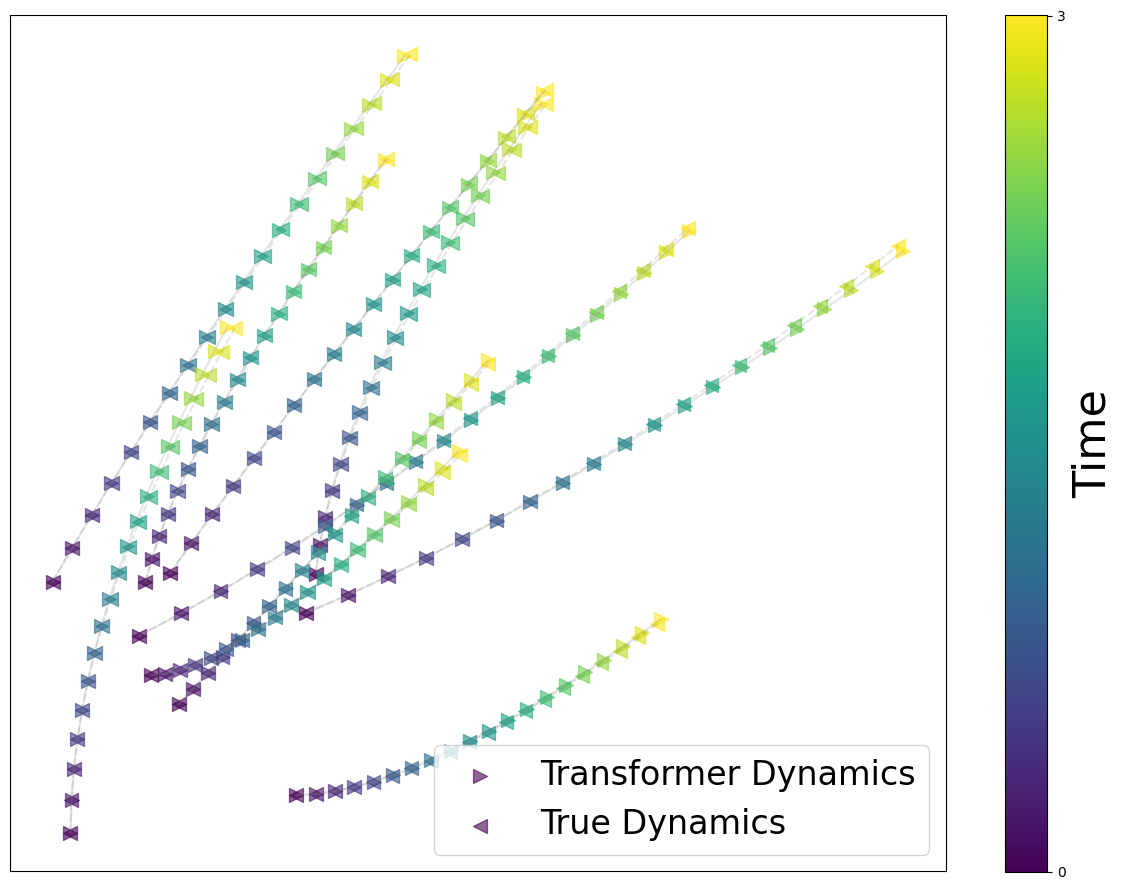

In [ ]:
plot_2d_scatter_time_comparison(x_t, y_t, x_cs, y_cs, time_steps=t_eval)

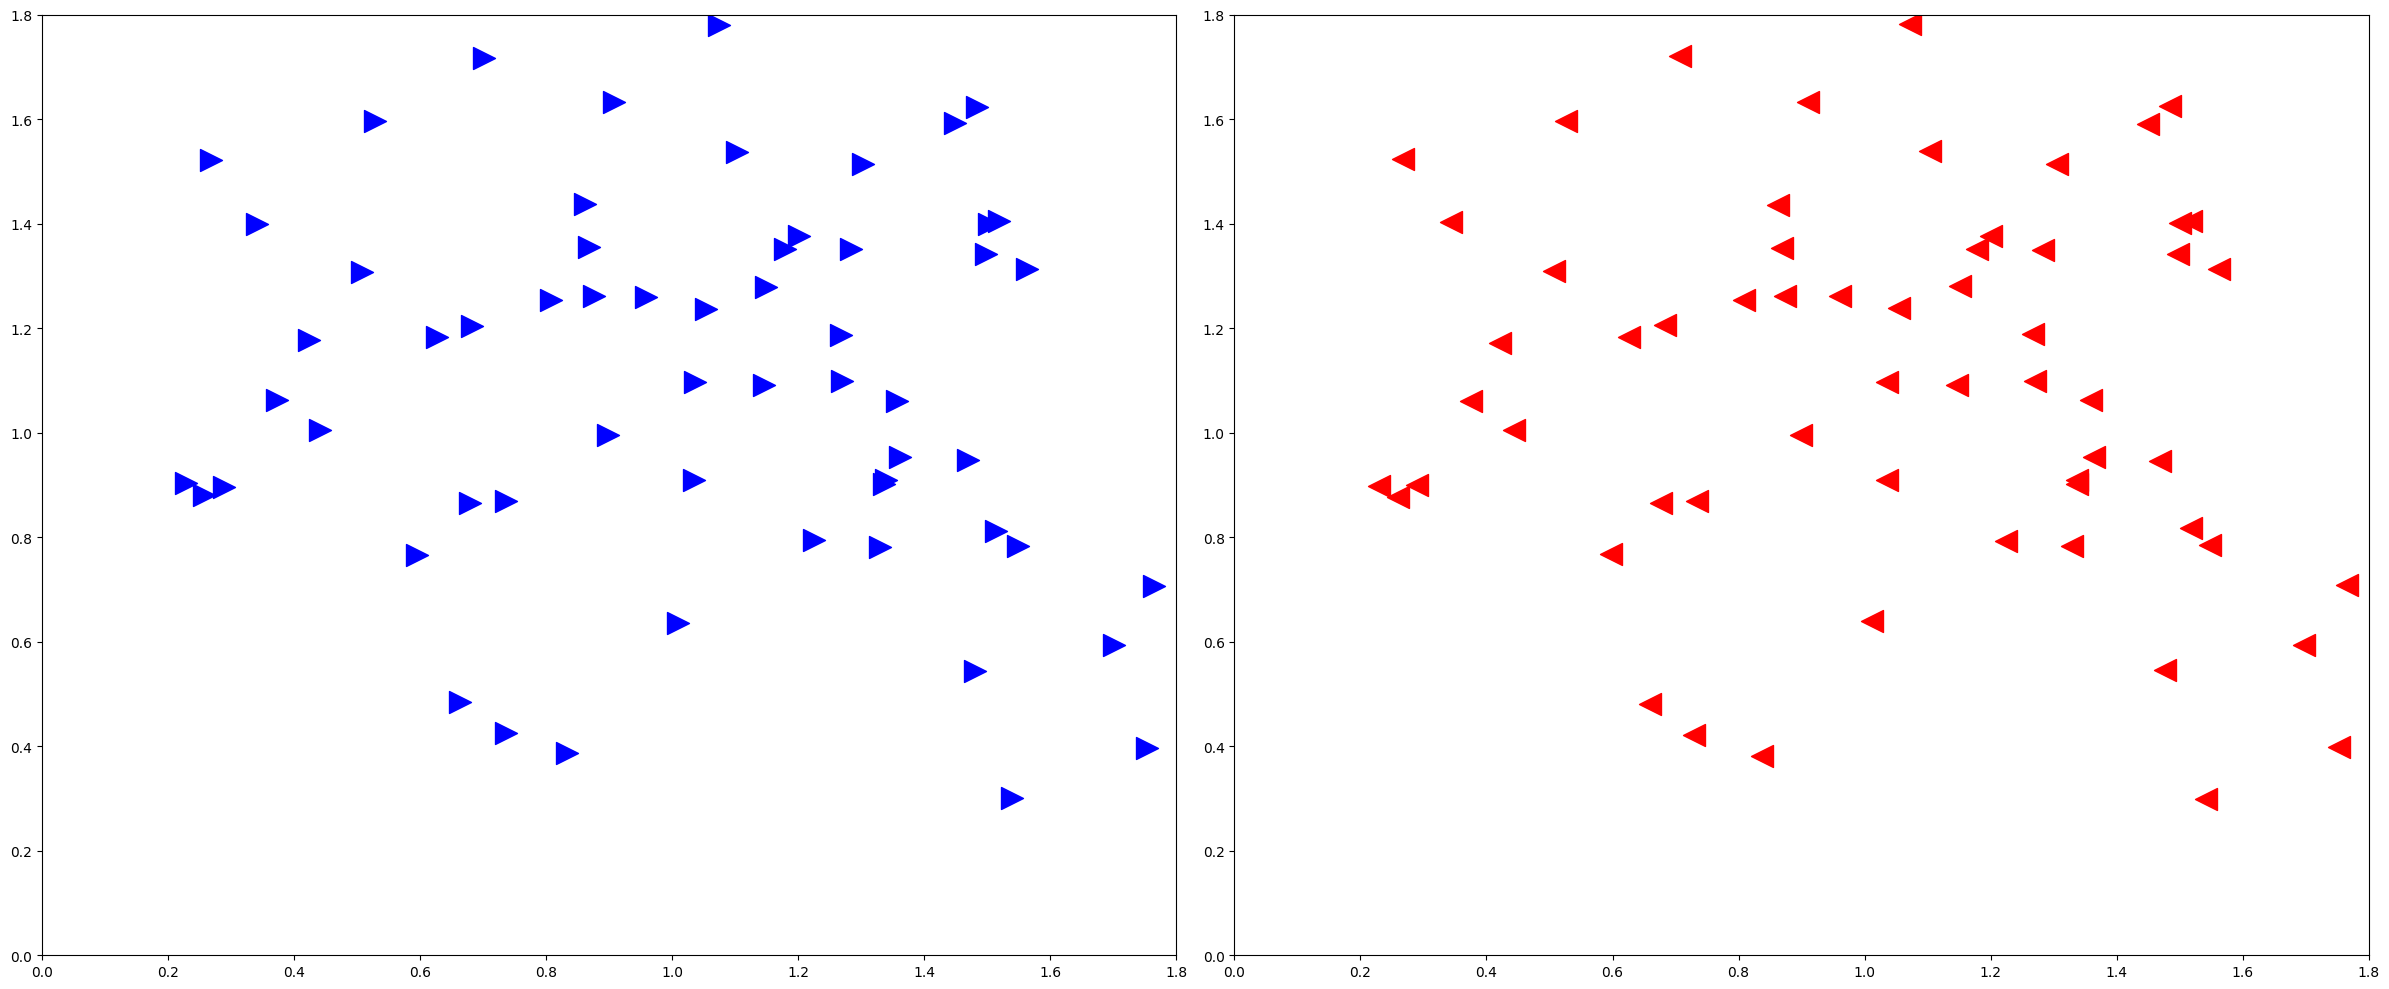

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
# fig.suptitle('Bird Flocking Dynamics')

# Initialize data
n_points = 50
x1, y1 = x_t[:,0], y_t[:,0]
x2, y2 = x_cs[:,0], y_cs[:,0]

# Create scatter plots
scat1 = ax1.scatter(x1, y1, c='blue', s=250, marker='>',)
scat2 = ax2.scatter(x2, y2, c='red', s=250, marker='<',)

# Set axis limits
ax1.set_xlim(0, 1.8)
ax1.set_ylim(0, 1.8)
ax2.set_xlim(0, 1.8)
ax2.set_ylim(0, 1.8)

# Update function for the animation
def update(frame):
    global x1, y1, x2, y2
    # Update data for the first scatter plot (circular motion)

    x1 = x_t[:,frame]
    y1 = y_t[:,frame]

    x2 = x_cs[:,frame]
    y2 = y_cs[:,frame]

    # Update the scatter plots
    scat1.set_offsets(np.c_[x1, y1])
    scat2.set_offsets(np.c_[x2, y2])

    return scat1, scat2

# Create the animation
writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim = FuncAnimation(fig, update, frames=500, interval=50, blit=True)

# Save the animation (uncomment to save)
anim.save('scatter_plots_evolution.mp4', writer=writer)

plt.tight_layout()
plt.show()